## Run LOMs form ANL and LANL
Jenna Ruzekowicz (jenna.ruzekowicz@nrel.gov), Caleb Phillips (caleb.phillips@nrel.gov), and Dmitry Duplyakin (dmitry.duplyakin@nrel.gov)

The purpose of this notebook is to read in inflow data and run the LOMs.

Output is saved into files named:

 > `bergey|oneenergy_anl|lanl_tid_windSource.csv.bz2`, where `windSource` is one of: `wtk`, `wtk_led_2018`, `wtk_led_2019`, `wtk_bc` (`bc` referes to bias corrected versions) 

### Work notes:

- Currently only ANL model
- Sites t007 and t074 are currently excluded becuase they don't have height data matching other sites
- Code looks for `"%s/%sv2.json" % (obstacle_data_dir, tid)` files for site obstacles inside `02 Input For Models` dir
- Sites t207 take a very long time! (slowest site)
- Notice that based on the plots at the end of the notebook ws-adjusted = ws (exactly) for quite a few sites. No negative ws-adjusted values observed yet for this set of inputs.
- `wind_sources = ["wtk", "wtk_led_2019", "wtk_bc"]` -- not including "wtk_led_2018" yet becuase 5-minuted data for 2018 is very large and processing will be slower than for other options here; will add it for final/more complete processing
- `overwrite` (if not set) flag allows to skip processing previously studied site x wind_source combinations (if output files with matching names are found)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from dw_tap.lom import run_lom
import os
import seaborn as sns
import glob

%matplotlib inline
%config InlineBackend.figure_format='retina'

/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
index = pd.read_csv("01 Bergey Turbine Data/bergey_sites.csv")
index.head()

APRS ID    AID Public Site Name Internal Site Name State   Latitude  \
0    t007  A2719          Fremont            Fremont    MN  43.918622   
1    t024  A2672           Washoe   Thomas Danzinger    NV  39.331088   
2    t028  A3479      Towamensing               Derr    PA  40.851353   
3    t034  A2715         Lycoming           Dan Poor    NY  43.524158   
4    t041  A2272         Rockford        Fossil Park    IA  43.047418   

    Longitude  Hub Height (m)      Lidar Quality  Lidar Collection Year  \
0  -91.899498              41  N/A (Legacy Data)                    NaN   
1 -119.820230              30                QL1                 2020.0   
2  -75.598395              30                QL2                 2019.0   
3  -76.372290              31                QL2                 2018.0   
4  -92.981674              37                QL2                 2020.0   

        Site Type                                         Site Notes  \
0           Rural  No lidar data. This turbine is absolutely surr...   
1  Rural/Suburban  Straight forward high desert site outside Reno...   
2        Suburban  Impressive amount of vegetation – some section...   
3           Rural                       Lakeshore, heavily forested.   
4           Rural  Very simple site, one building and a couple sm...   

   Building Data Quality          Turbine  \
0  Partial, some missing  Bergey Excel 10   
1          Good coverage  Bergey Excel 10   
2  Partial, some missing  Bergey Excel 10   
3          Good coverage  Bergey Excel 10   
4          Good coverage  Bergey Excel 10   

             Periods with Consistent Generation Data  \
0  2012/01 - 2013/12 (outage starting mid-2013/11...   
1                                  2011/01 - 2022/12   
2                                  2011/01 - 2022/12   
3               2013/01 - 2017/12, 2019/01 - 2021/12   
4               2013/01 - 2013/12, 2015/01 - 2022/12   

                             Met Tower  Met Tower Latitude  \
0  mn_prairiestar.PROPRIETARY.pruf.csv              43.673   
1                                  NaN                 NaN   
2                                  NaN                 NaN   
3                     ny_oswego.qc.csv              43.464   
4                                  NaN                 NaN   

   Met Tower Longitude  Measurement Height (m) Measurement Privacy  
0              -92.698                    50.0         Proprietary  
1                  NaN                     NaN                 NaN  
2                  NaN                     NaN                 NaN  
3              -76.511                    15.0              Public  
4                  NaN                     NaN                 NaN

### Select which sites need to be processed and wind data source

In [6]:
# Small test with several sites
#selected = ["t133", "t135"]

# Process all sites:
selected = index["APRS ID"].tolist()

# Remove 2 sites that currently don't have obstacle descriptions with the heights based on lidar data
selected = [x for x in selected if not(x in ["t007", "t074"])]
print(selected)

wind_sources = ["wtk_bc"] # ["wtk", "wtk_led_2019"] # One of: ["wtk", "wtk_led_2018", "wtk_led_2019"]

['t024', 't028', 't034', 't041', 't083', 't114', 't133', 't135', 't139', 't140', 't169', 't170', 't182', 't183', 't192', 't207', 't221']


### Load wind data

In [7]:
atmospheric_inputs = {}

for wind_source in wind_sources:

    if wind_source == "wtk":

        wtk_df = pd.read_csv("01 Bergey Turbine Data/wtk.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_df[wtk_df["tid"] == tid].reset_index(drop=True)
            #display(dfs_by_tid[tid].head(3))
        
        atmospheric_inputs[wind_source] = dfs_by_tid

    elif wind_source == "wtk_led_2018":

        wtk_led_2018 = pd.read_csv("01 Bergey Turbine Data/wtk_led_2018.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_led_2018[wtk_led_2018["tid"] == tid].copy().reset_index(drop=True)
            dfs_by_tid[tid]["datetime"] = dfs_by_tid[tid]["packet_date"]
            #display(dfs_by_tid[tid].head(3))
        
        atmospheric_inputs[wind_source] = dfs_by_tid

    elif wind_source == "wtk_led_2019":

        wtk_led_2019 = pd.read_csv("01 Bergey Turbine Data/wtk_led_2019.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_led_2019[wtk_led_2019["tid"] == tid].copy().reset_index(drop=True)
            dfs_by_tid[tid]["datetime"] = dfs_by_tid[tid]["packet_date"]
            #display(dfs_by_tid[tid].head(3))
            
        atmospheric_inputs[wind_source] = dfs_by_tid

    elif wind_source == "wtk_bc":
        wtk_bc_df = pd.read_csv("02 Bias Correction/wtk_bc.csv.bz2")
        
        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_bc_df[wtk_bc_df["tid"] == tid].reset_index(drop=True)
            
            # Actually use bias corrected wind speeds for further steps (overwrite original ws)
            dfs_by_tid[tid]["ws"] = dfs_by_tid[tid]["ws_bc"]
            
            #display(dfs_by_tid[tid].head(3))
        
        atmospheric_inputs[wind_source] = dfs_by_tid
        
    else:
        print("Unsupported wind_source selected:", wind_source)

### Load obstacle data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 25.64it/s]


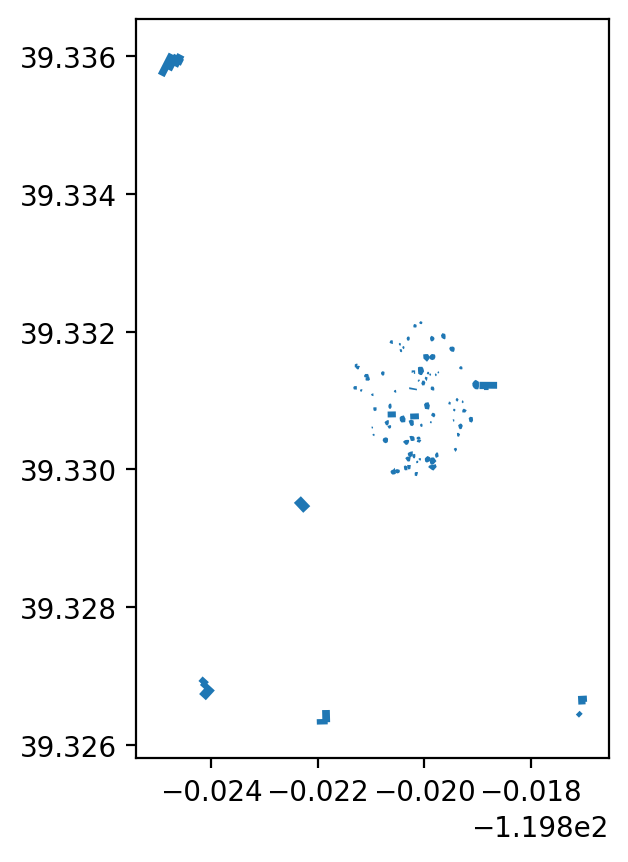

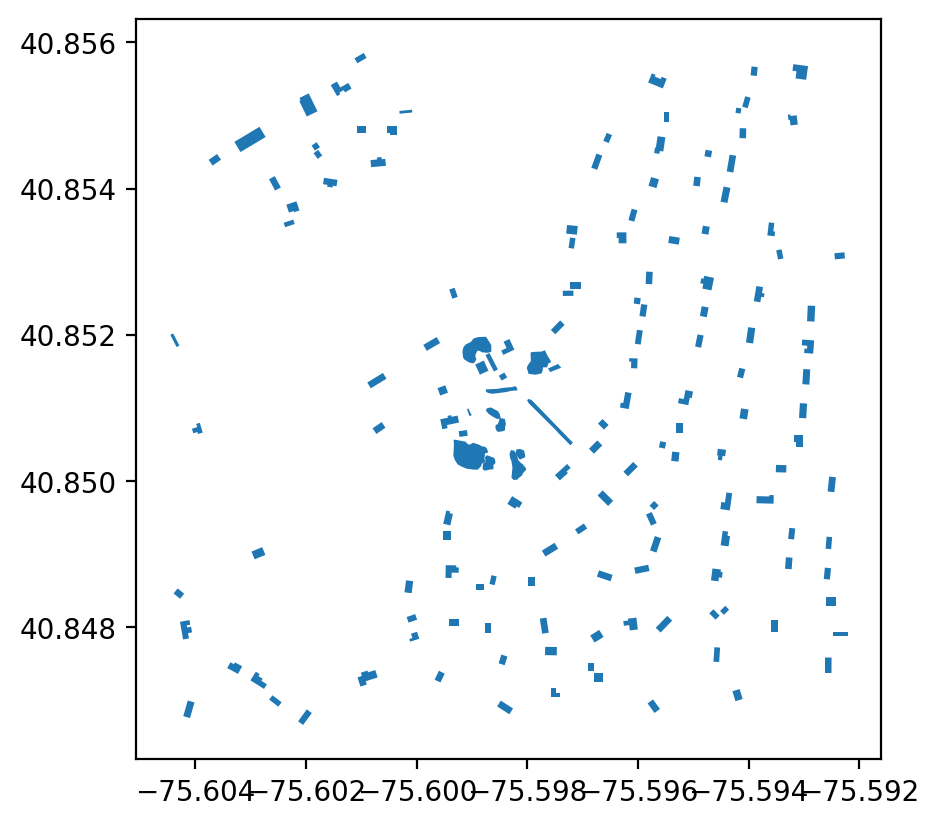

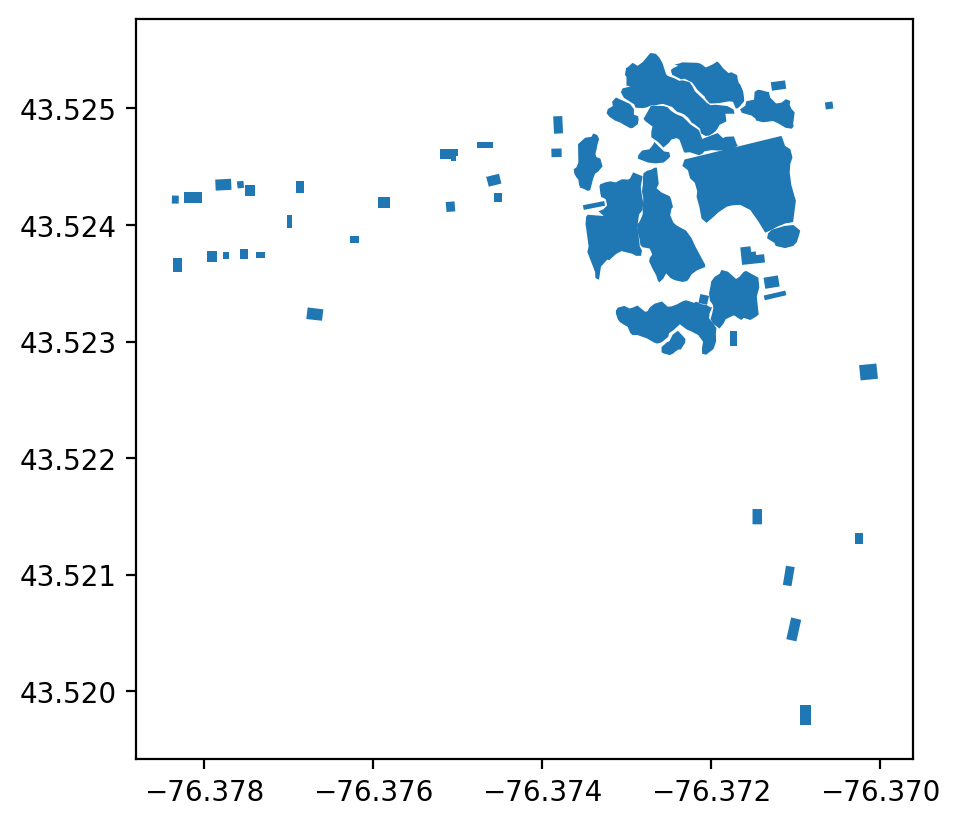

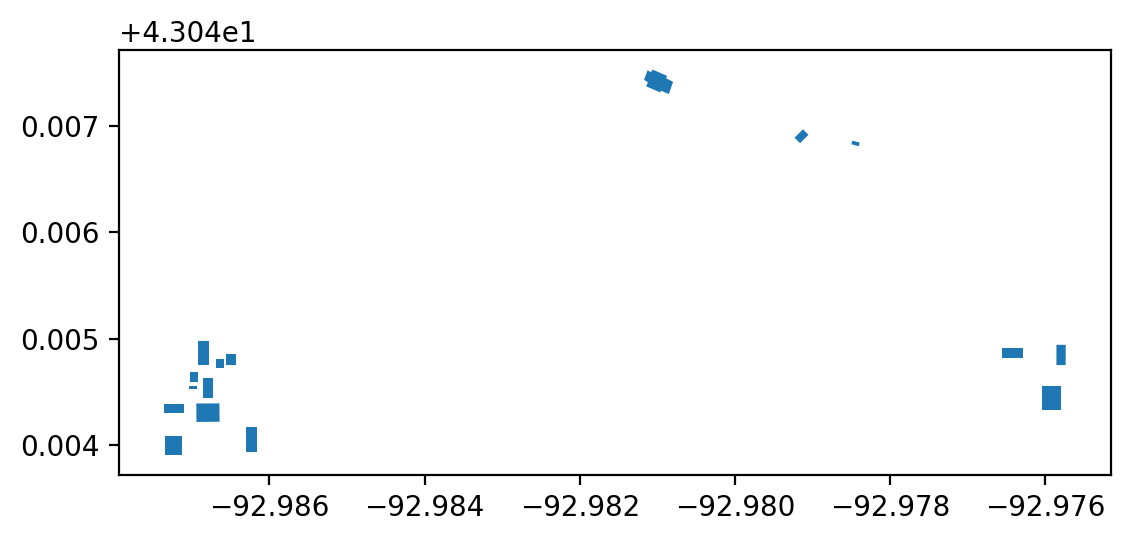

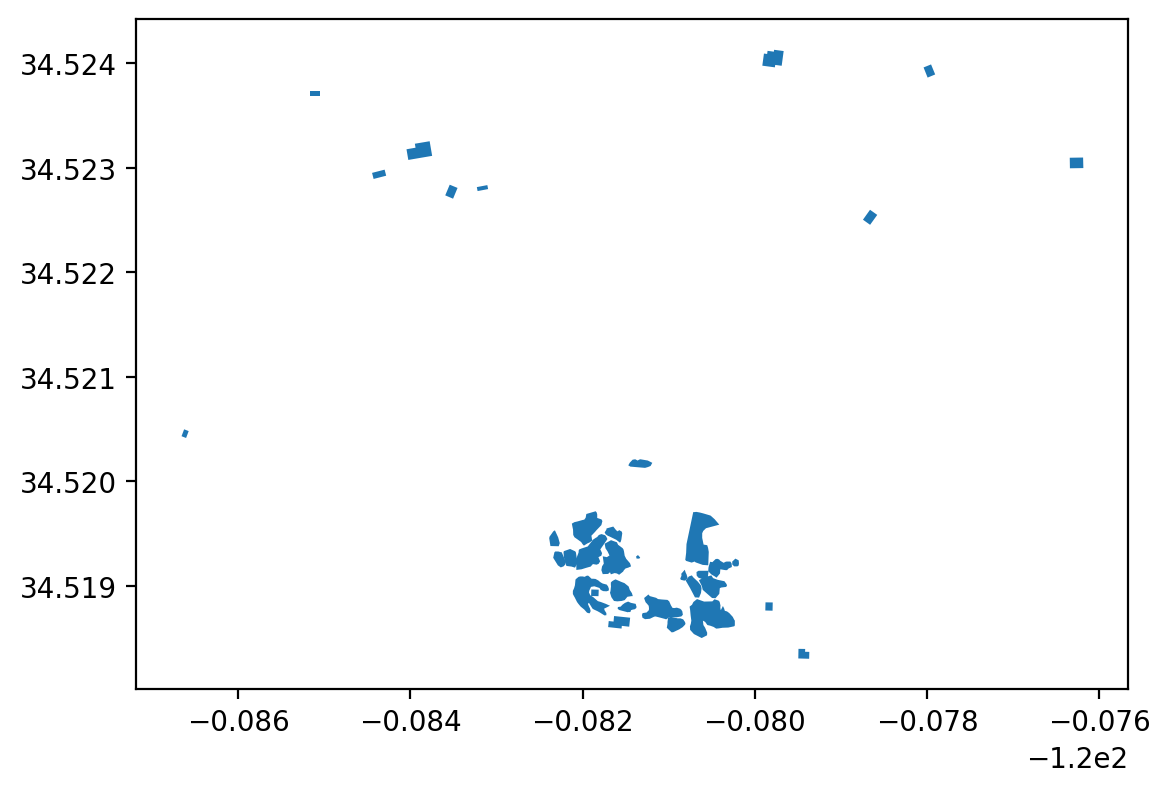

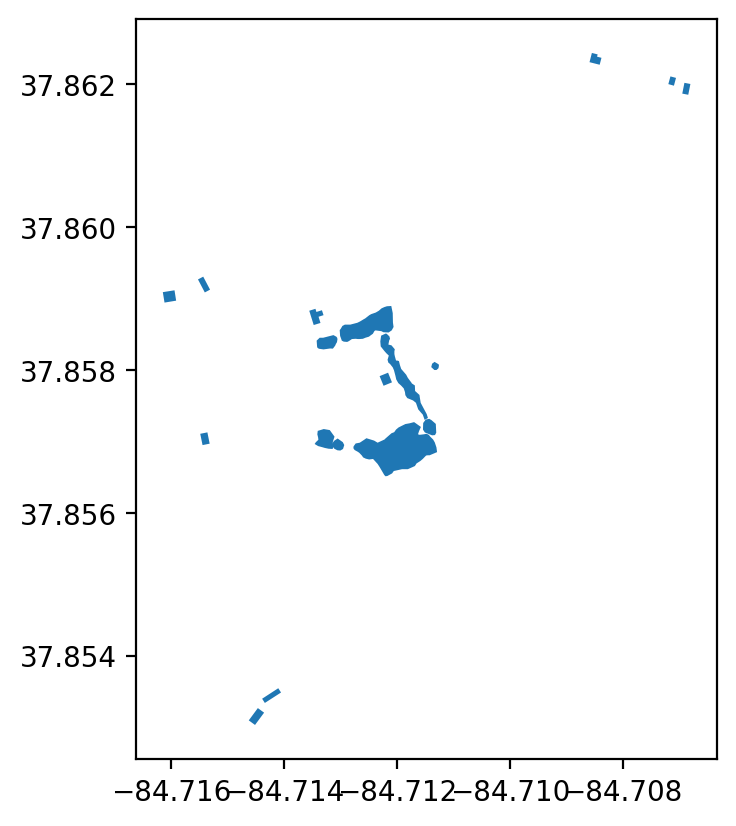

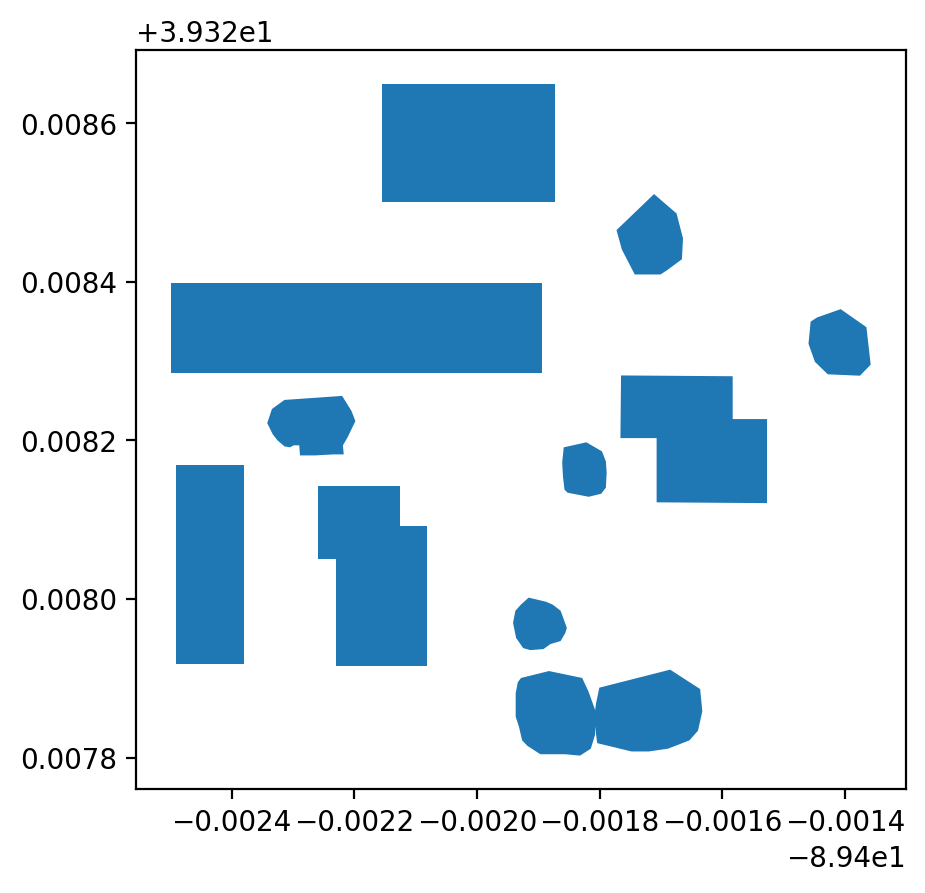

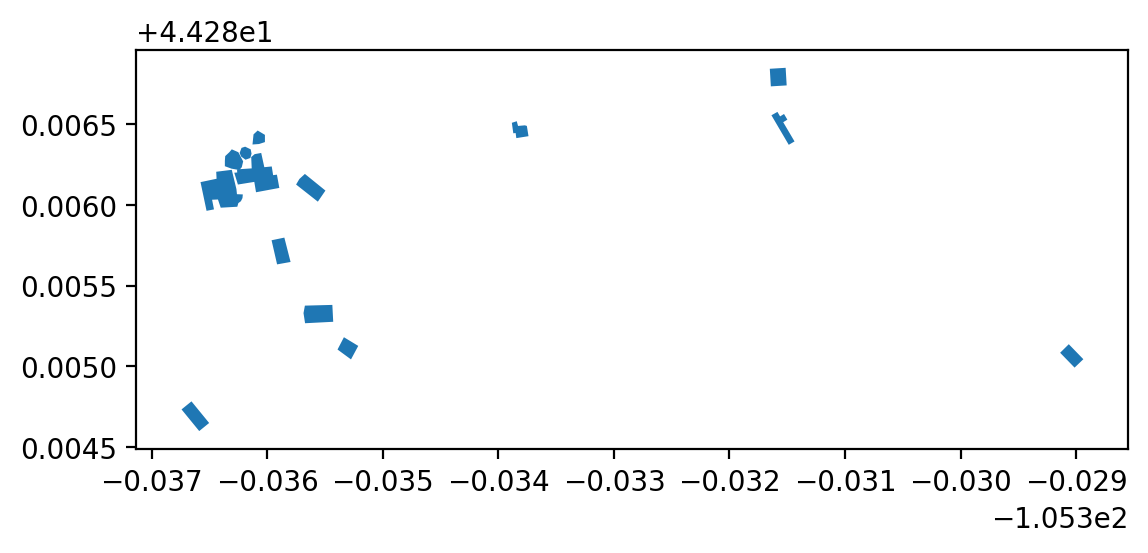

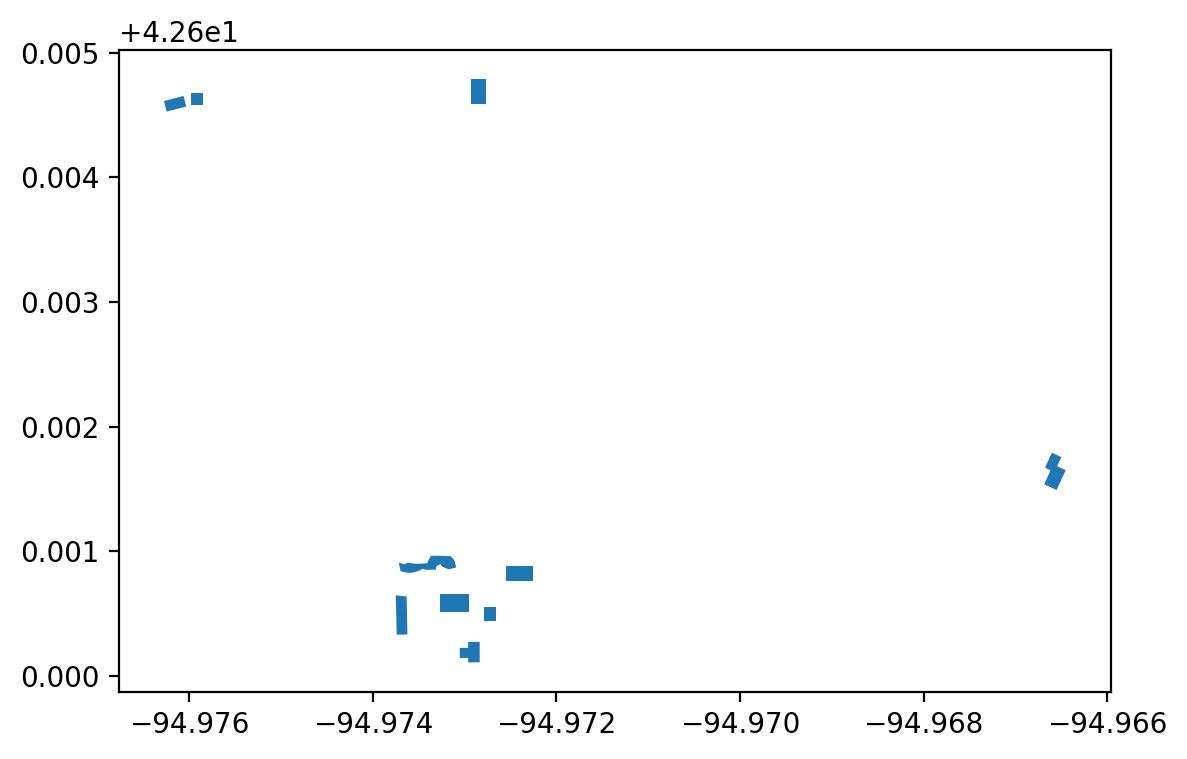

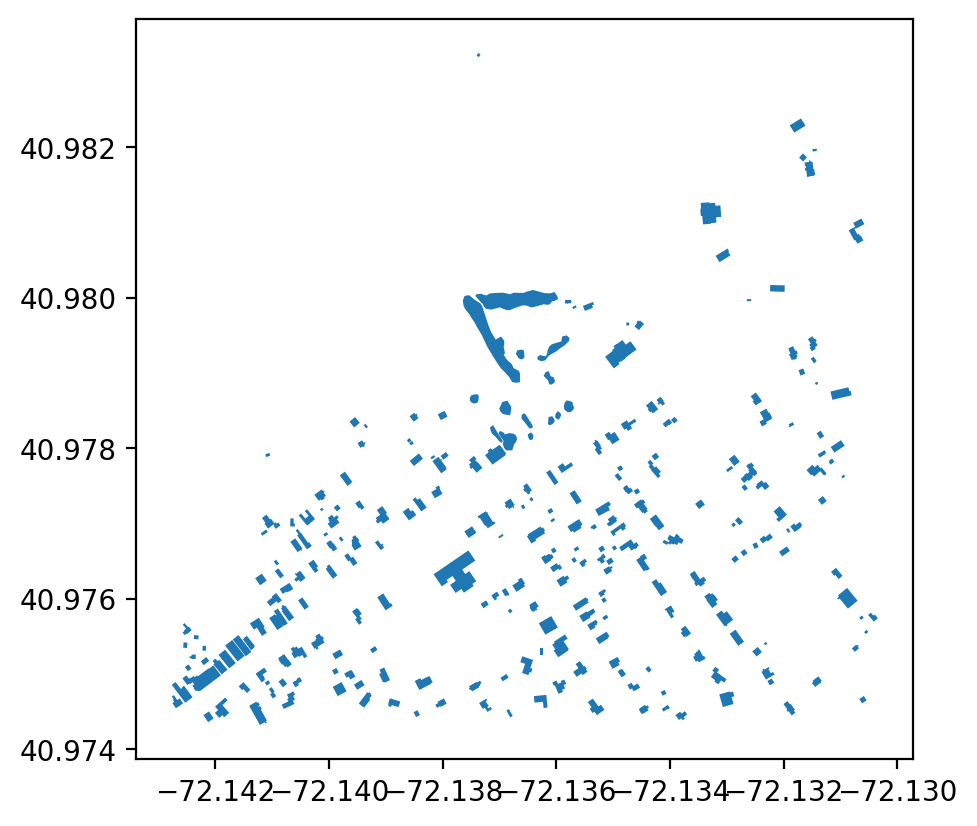

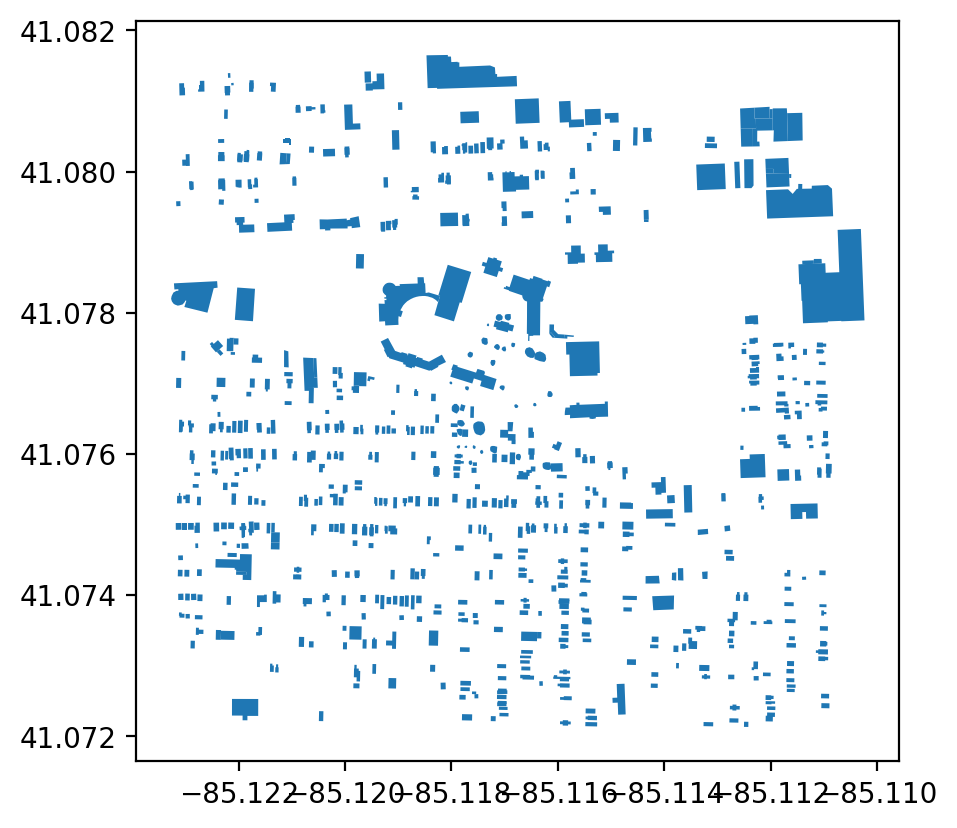

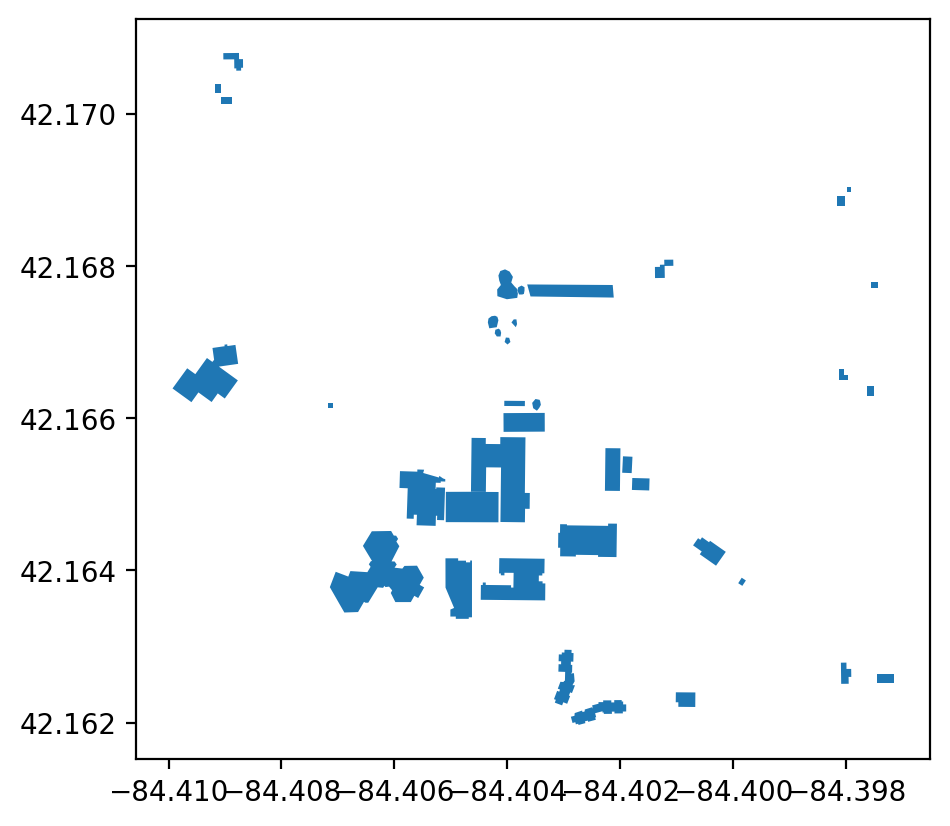

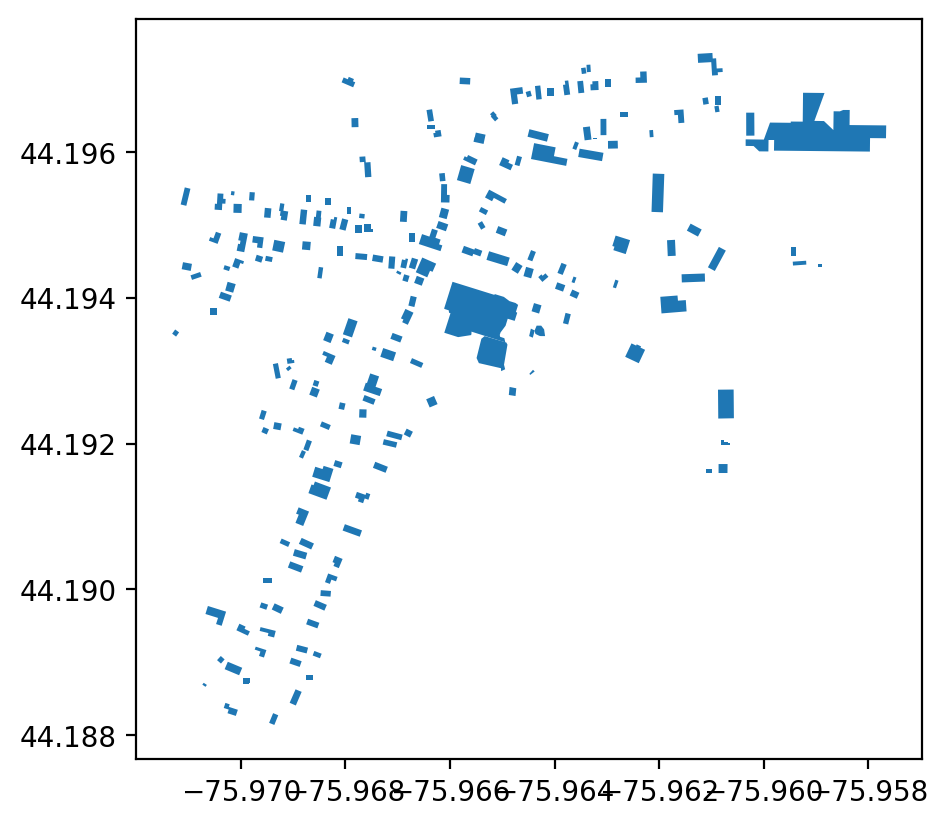

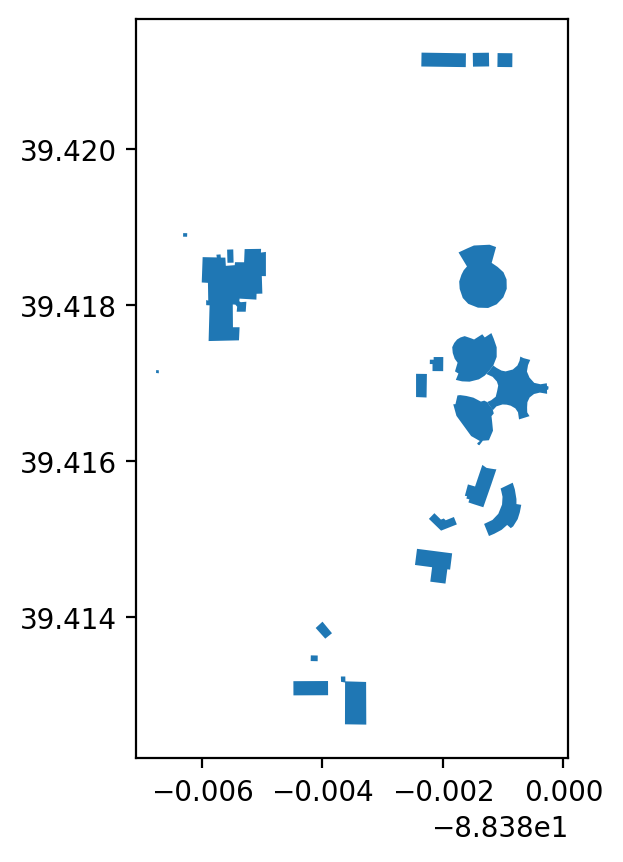

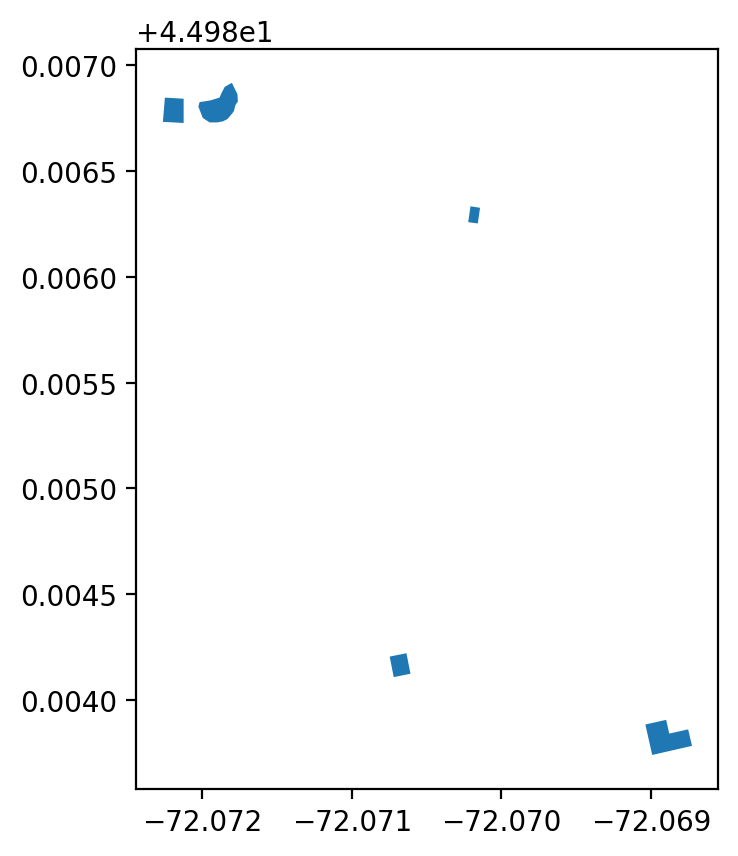

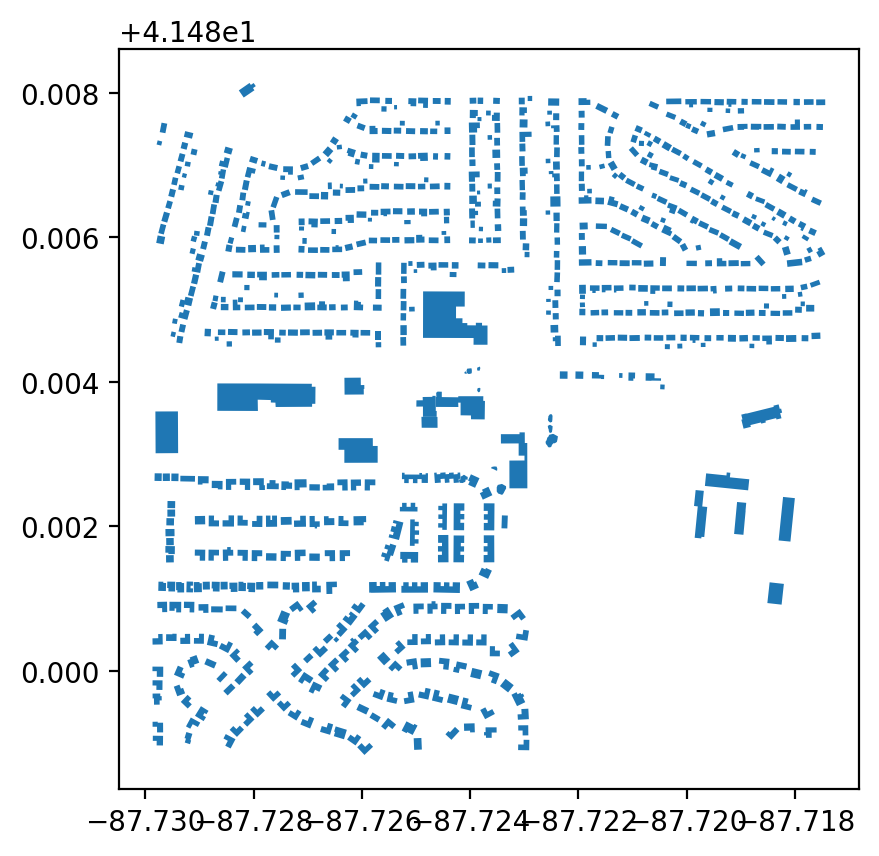

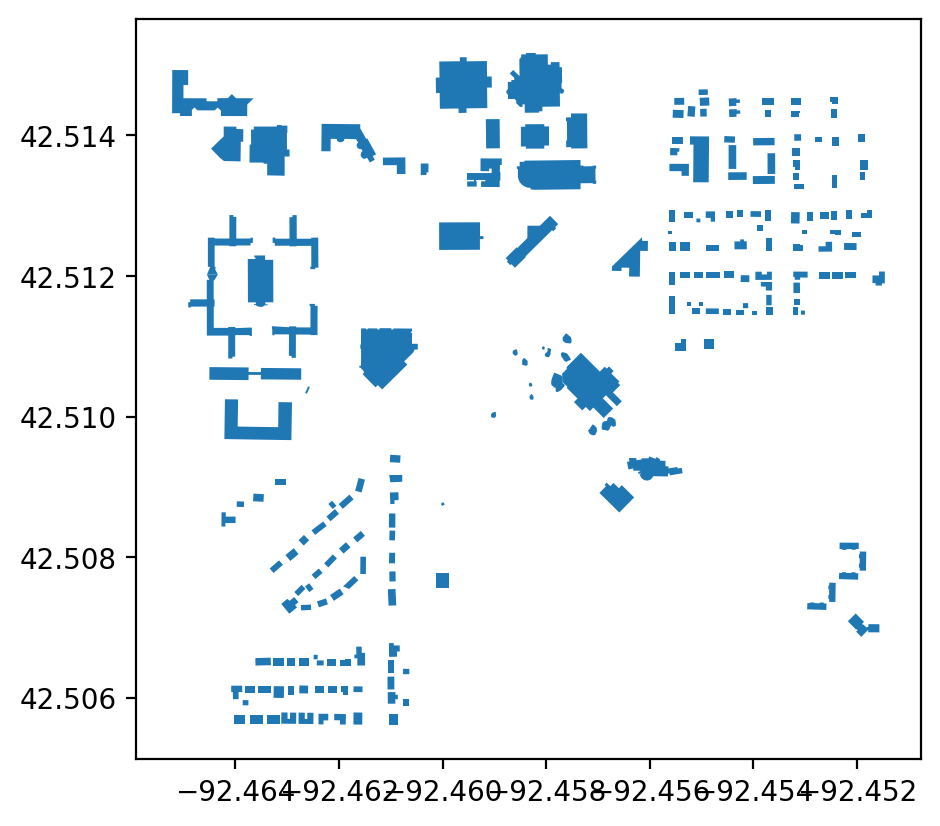

In [10]:
def filter_obstacles(obstacle_df):
    selected = obstacle_df[obstacle_df["height_median"] > 1.0].copy().reset_index(drop=True)
    selected["height"] = selected["height_median"]
    return selected[["height", "geometry"]]

obstacle_inputs = {}
for tid in tqdm(selected):
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    if os.path.exists(obstacle_data_file):
        obstacle_df = filter_obstacles(gpd.read_file(obstacle_data_file))
        obstacle_inputs[tid] = obstacle_df
        #display(obstacle_inputs[tid])
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)
    
# Quick vis:
for tid, obstacle_df in obstacle_inputs.items():
    obstacle_df.plot()

### Run ANL's LOM

In [11]:
# This flag allows overwriting previously saved files with results if they are found in the specified directory dest_dir 
overwrite = False

# Will be used in the filenames
site_type = "bergey"

# Will be used in the filenames
model_type = "anl"

dest_dir = "03 Model Outputs"
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)    
    
for tid in tqdm(selected):
    
    for wind_source in wind_sources:
        
        dest_filename = "%s/%s_%s_%s_%s.csv.bz2" % (dest_dir, site_type, model_type, tid, wind_source)
        if (not overwrite) and (os.path.exists(dest_filename)):
            print("Found previously saved %s); overwrite flag is off. Skipping to next config." % (dest_filename))
        else:
            row = index[index["APRS ID"] == tid].iloc[0]
            #print(row)
            lat = row["Latitude"]
            lon = row["Longitude"]
            z_turbine = row["Hub Height (m)"]
            xy_turbine = [np.array([lon, lat])]

            predictions_df = run_lom(atmospheric_inputs[wind_source][tid], \
                                     obstacle_inputs[tid], \
                                     xy_turbine, z_turbine, \
                                     check_distance=True)

            # Add LOM output back to the more complete input dataframe
            atmospheric_inputs[wind_source][tid]["ws-adjusted"] = predictions_df["ws-adjusted"]   
            atmospheric_inputs[wind_source][tid].to_csv(dest_filename, index=False)

  0%|                                                                                                                                                  | 0/17 [00:00<?, ?it/s]2023-04-18 14:25:19.086541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
  6%|████████                                                                                                                                  | 1/17 [00:02<00:32,  2.00s/it]

Done with loading ML model.


 47%|████████████████████████████████████████████████████████████████▉                                                                         | 8/17 [06:09<03:57, 26.42s/it]/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/LOMvectorized.py:302: RuntimeWarning: divide by zero encountered in log
  predictions = np.log(predictions)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [1:27:52<00:00, 310.13s/it]


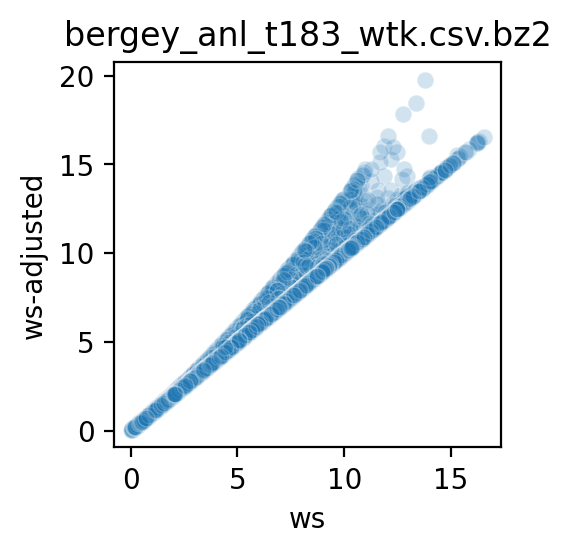

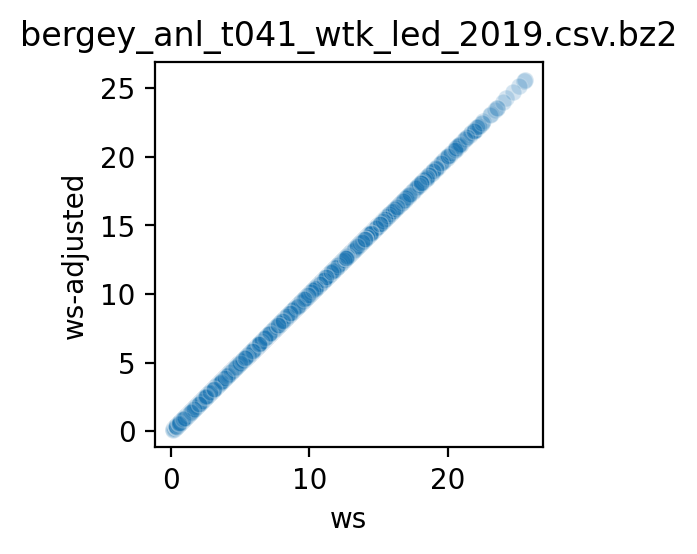

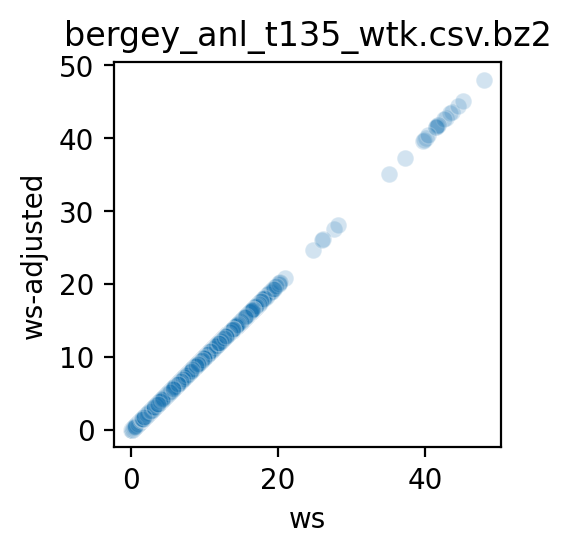

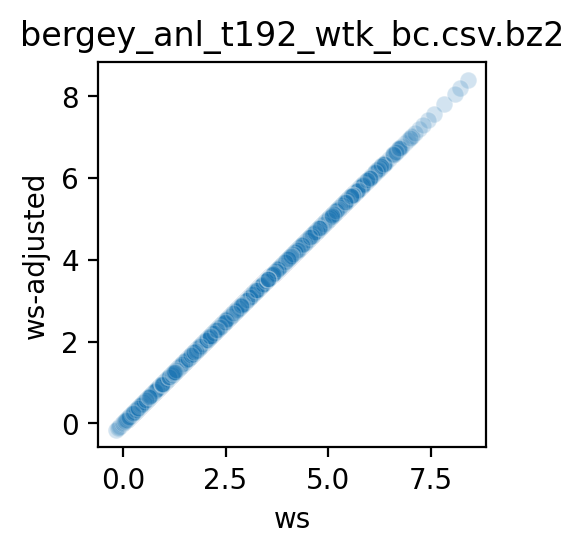

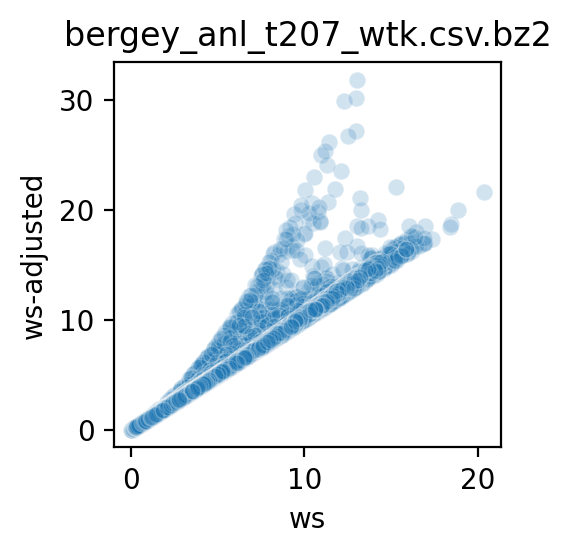

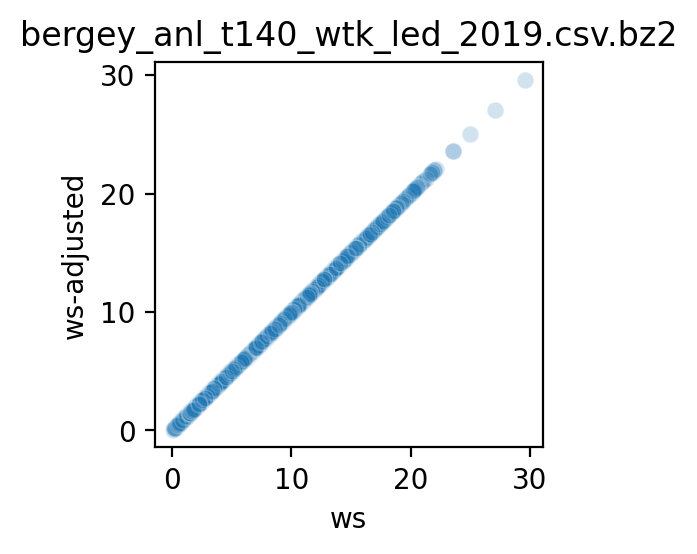

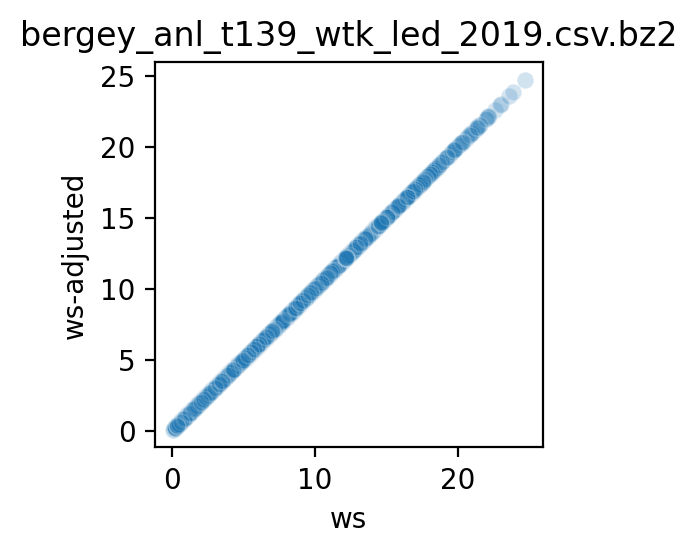

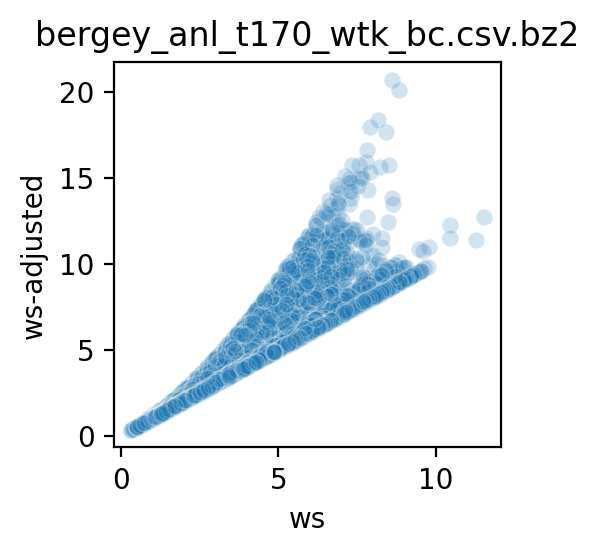

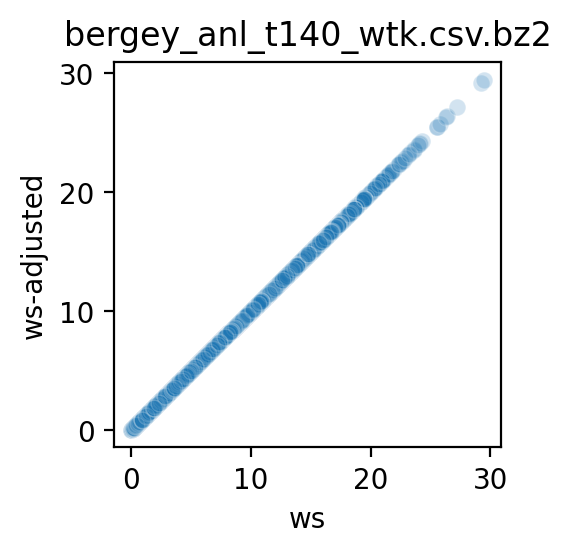

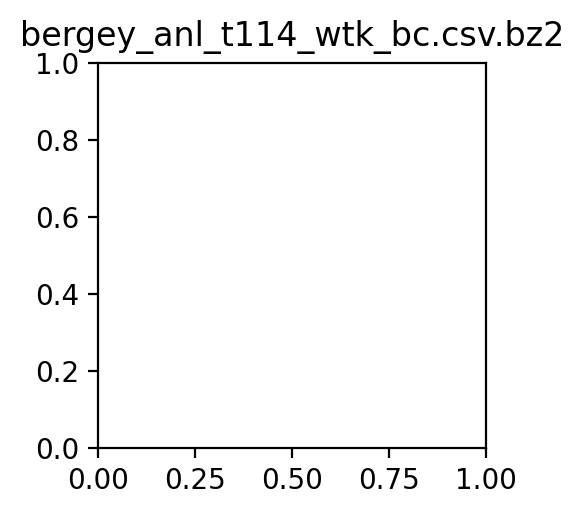

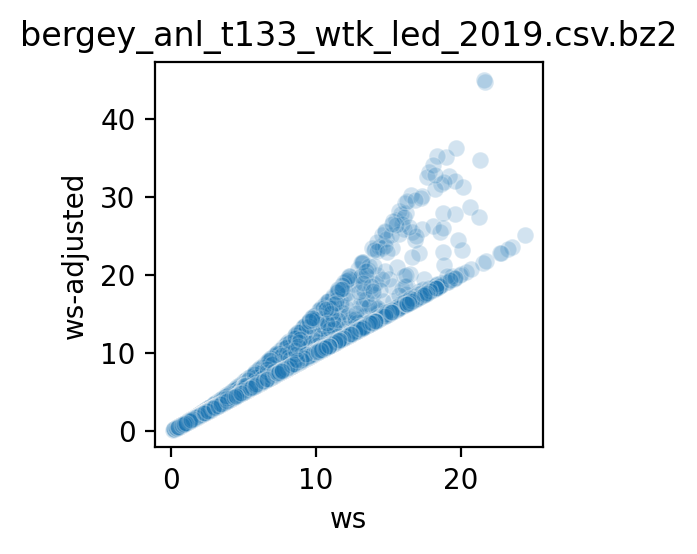

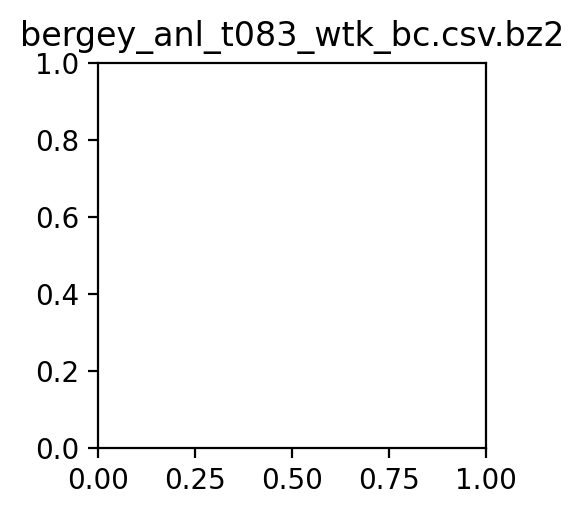

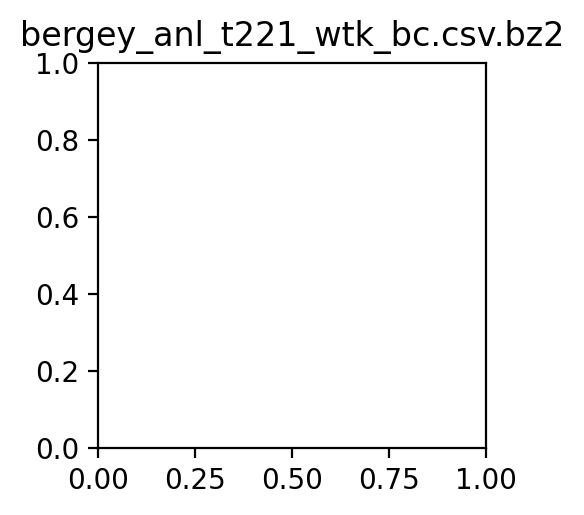

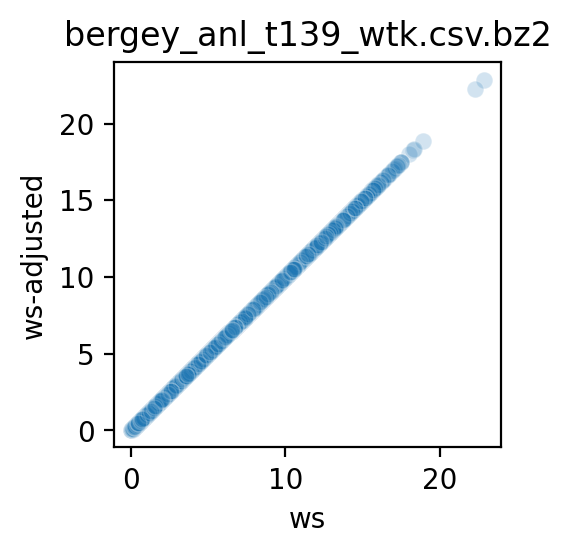

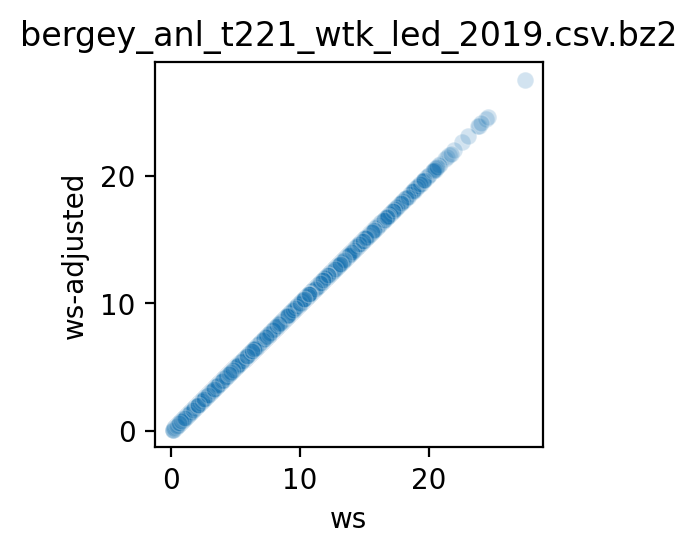

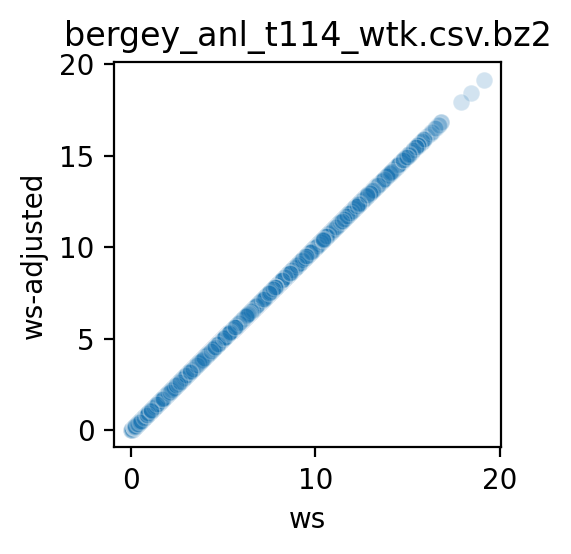

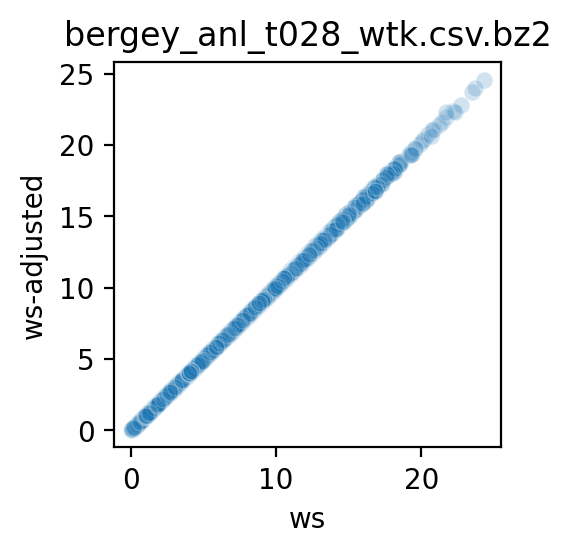

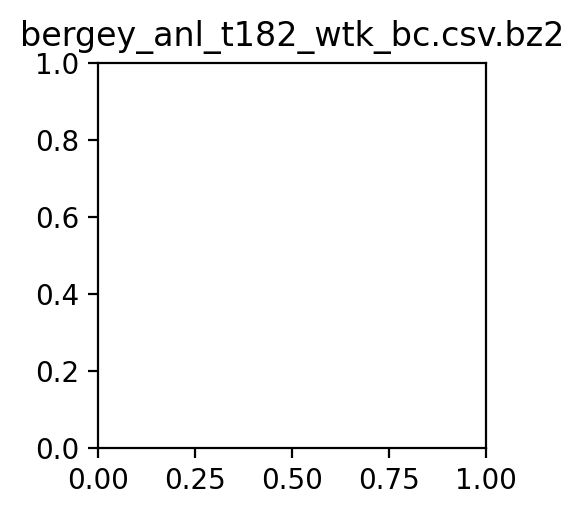

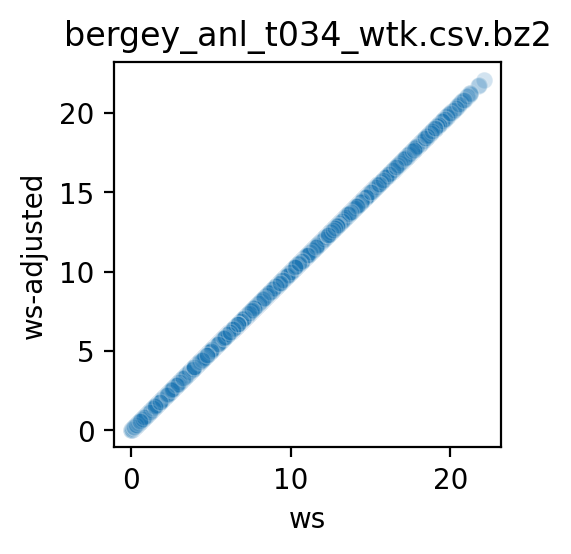

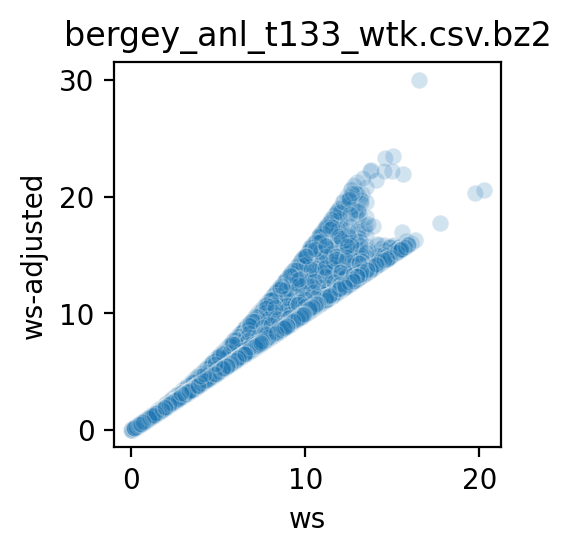

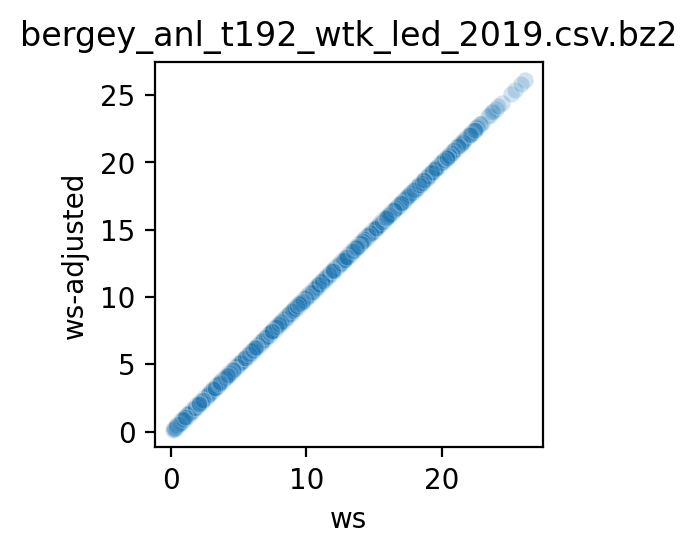

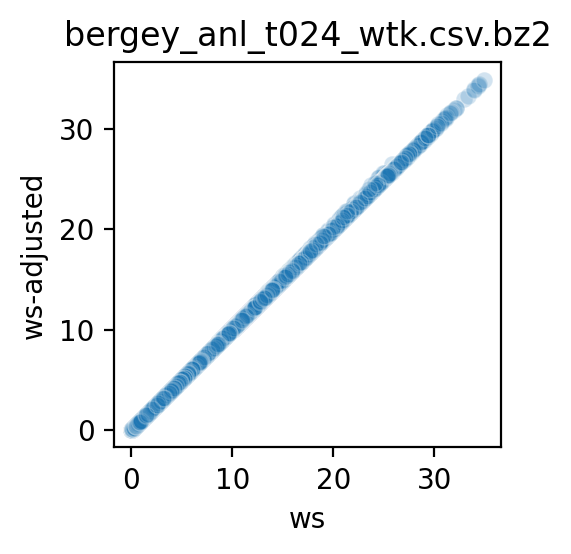

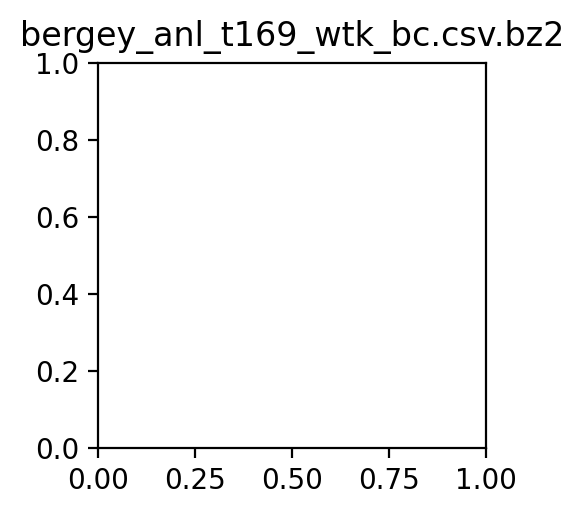

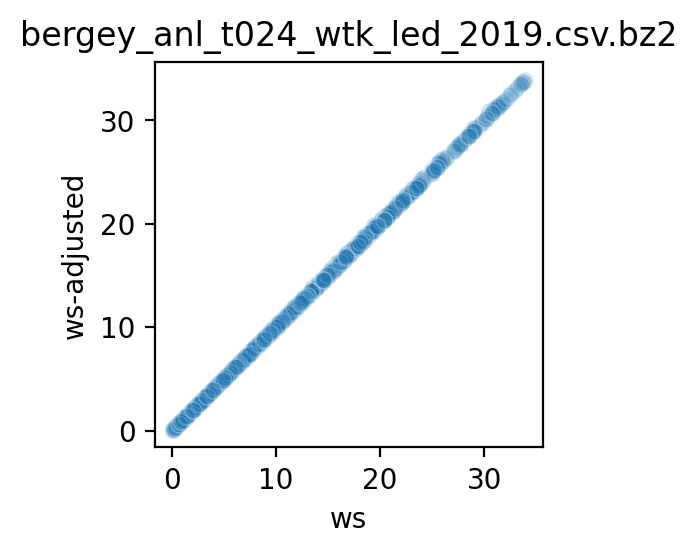

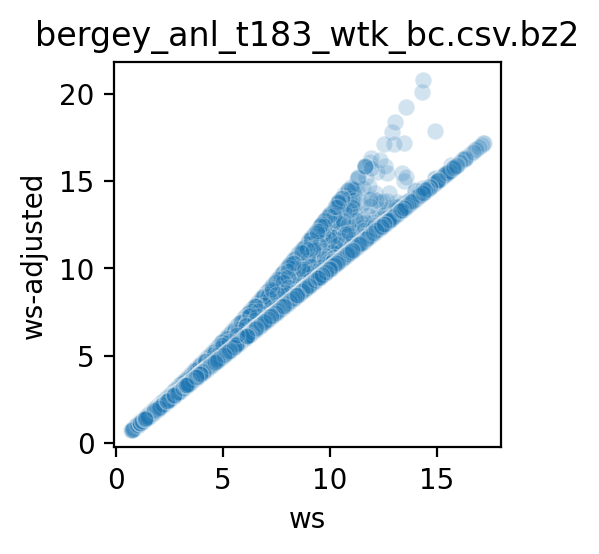

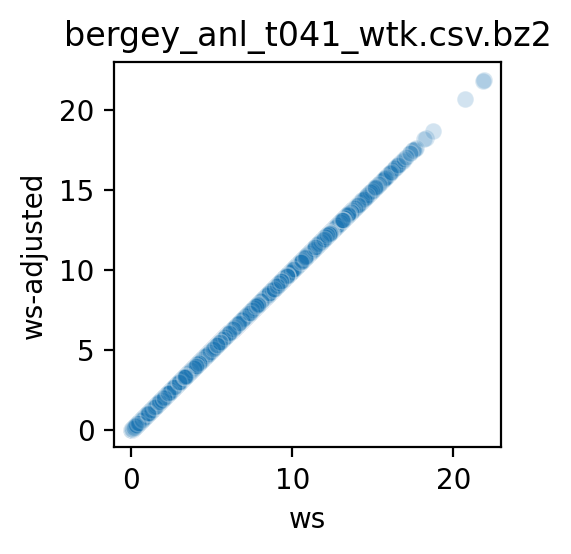

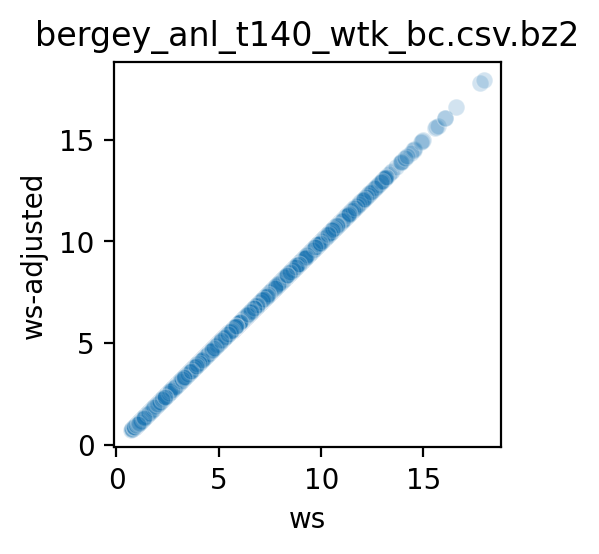

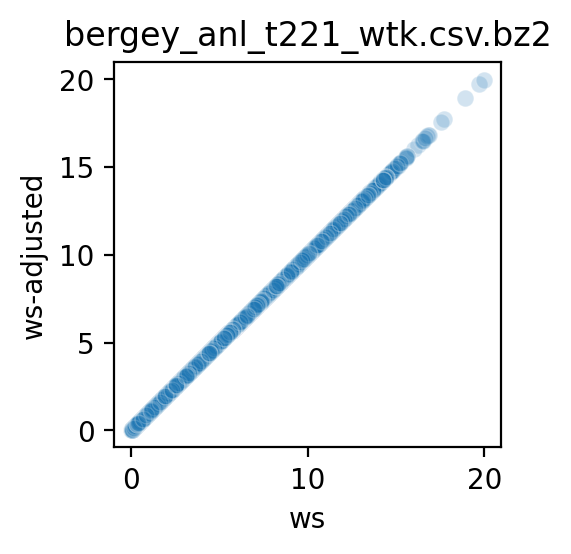

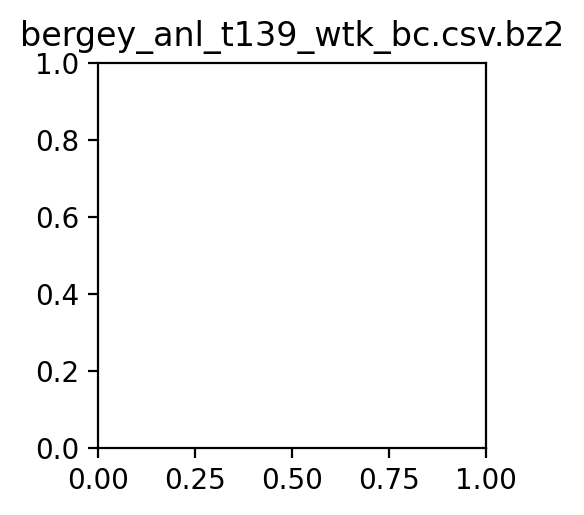

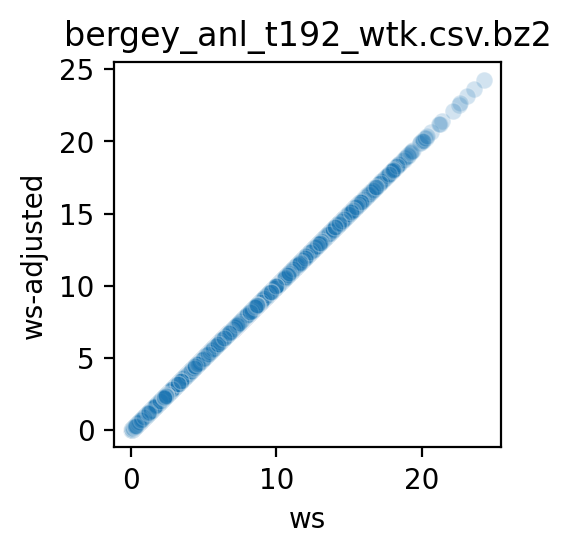

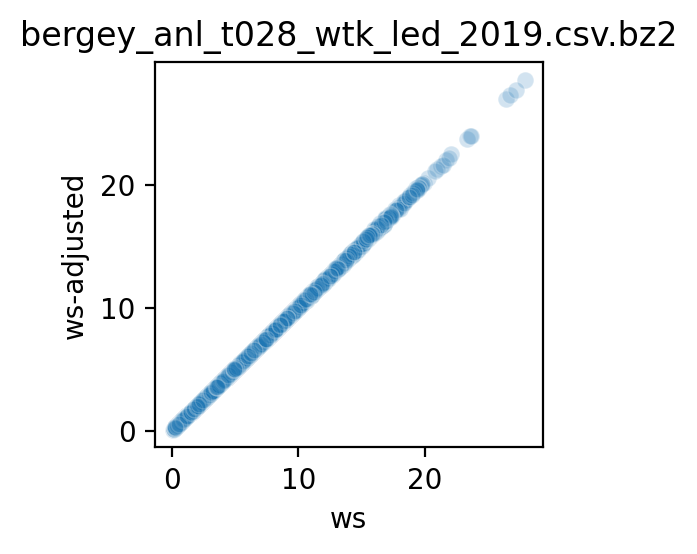

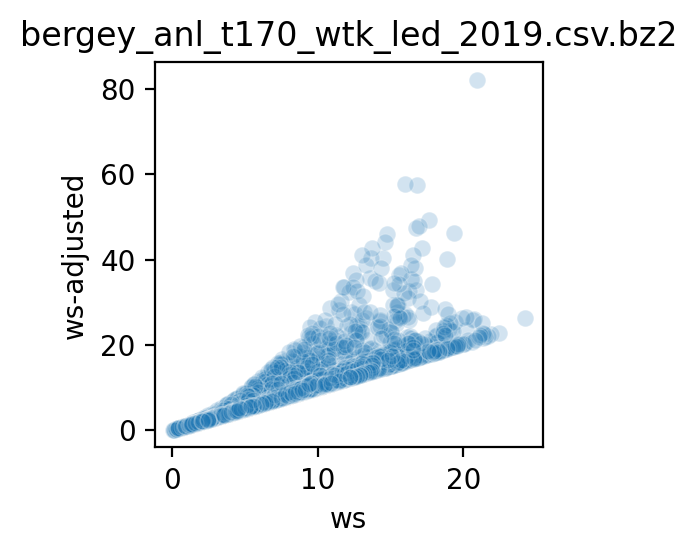

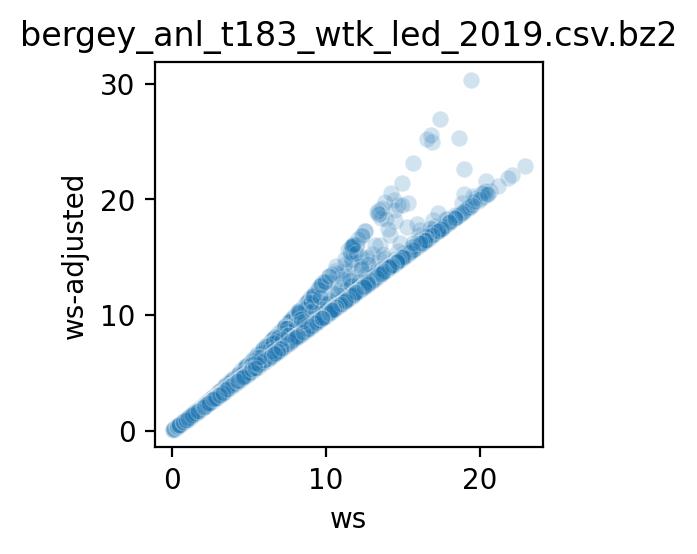

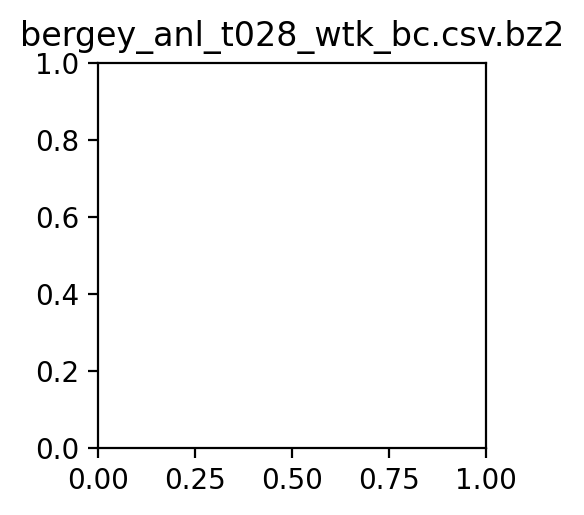

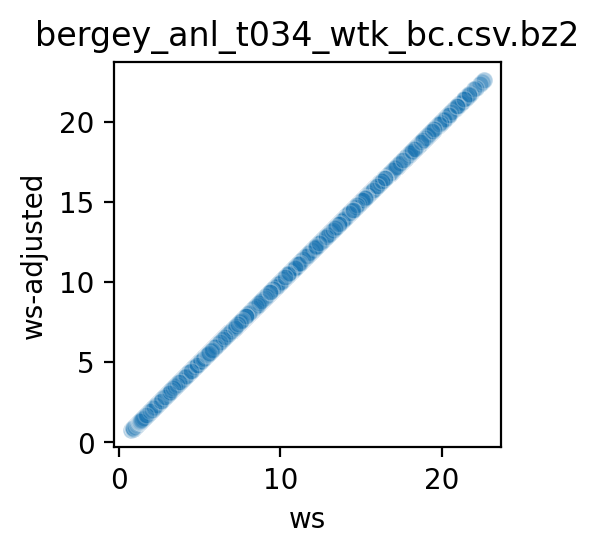

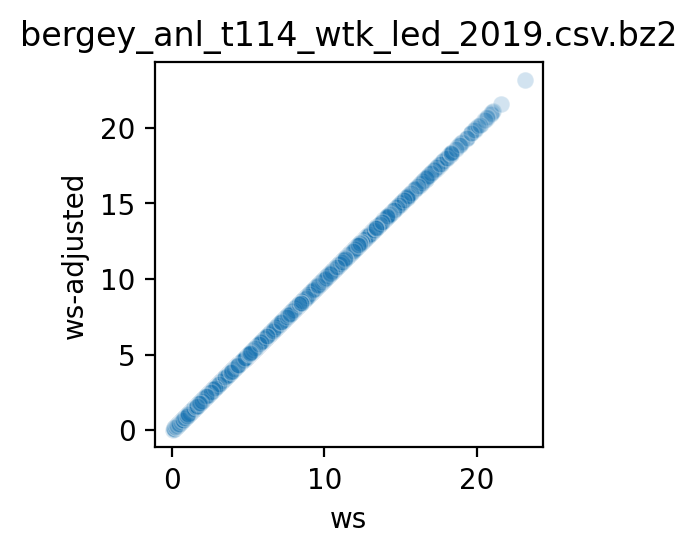

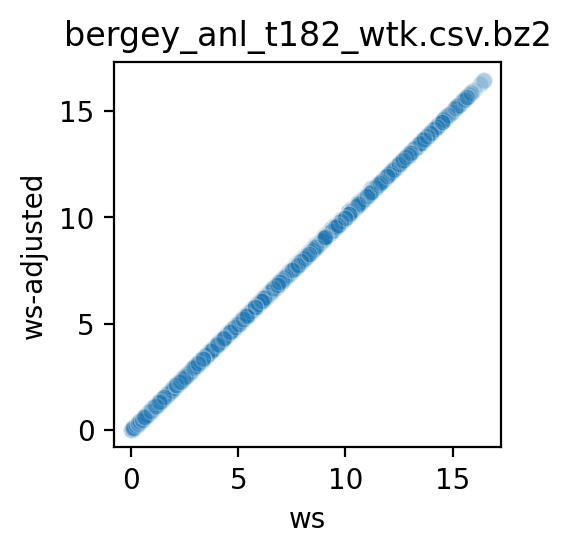

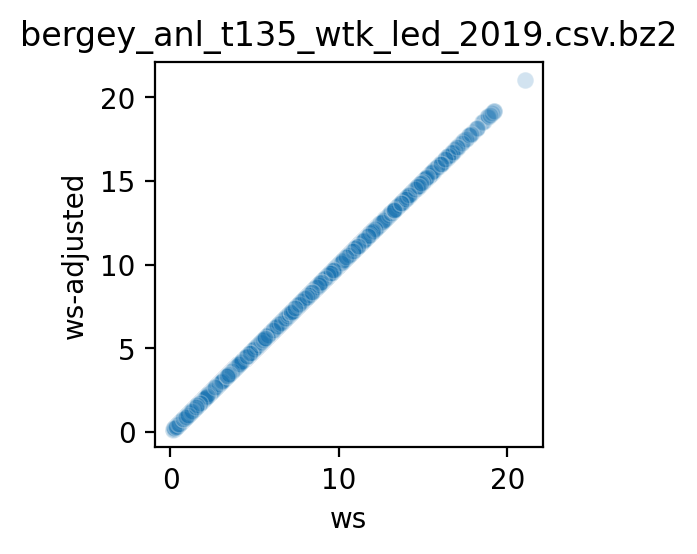

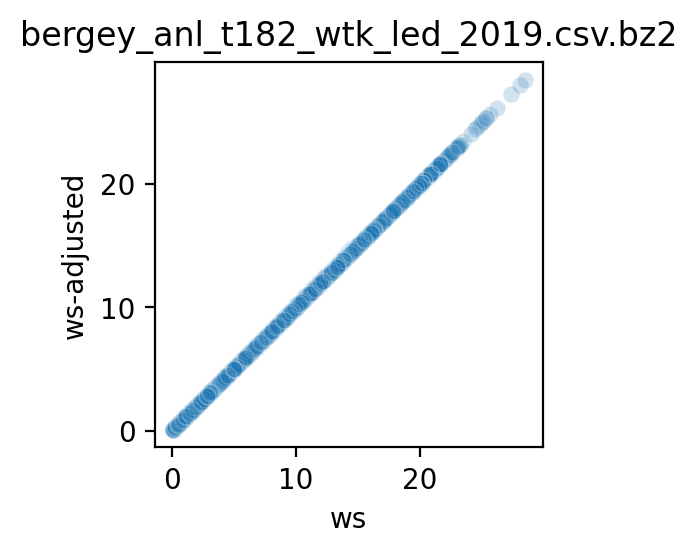

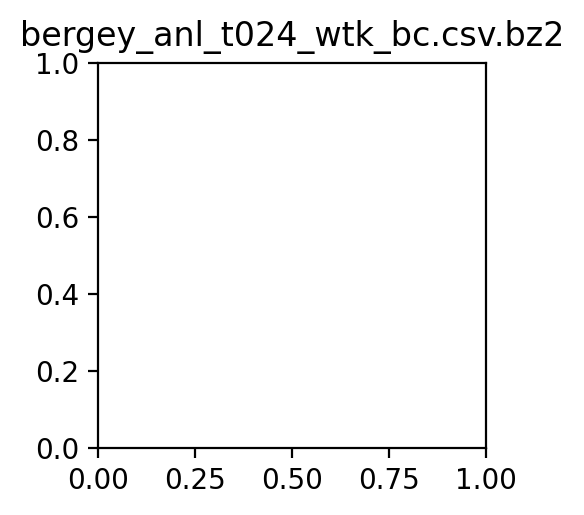

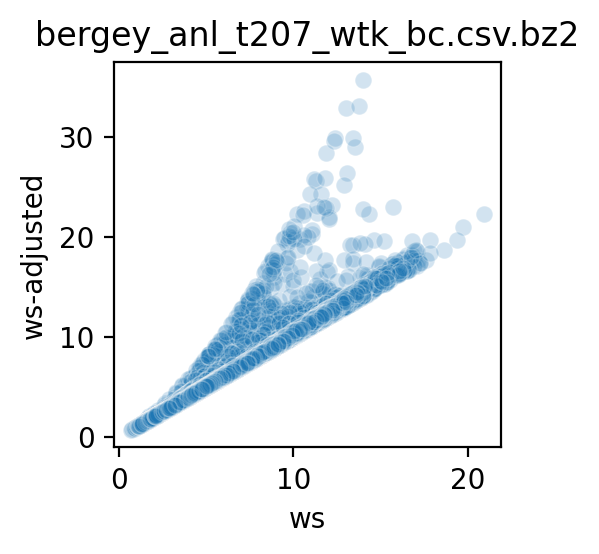

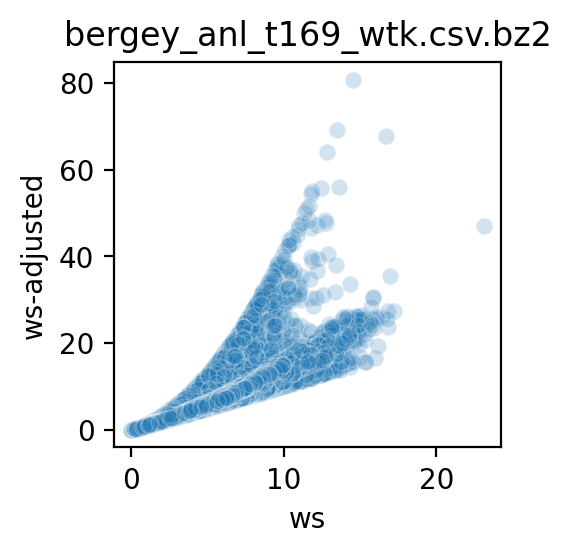

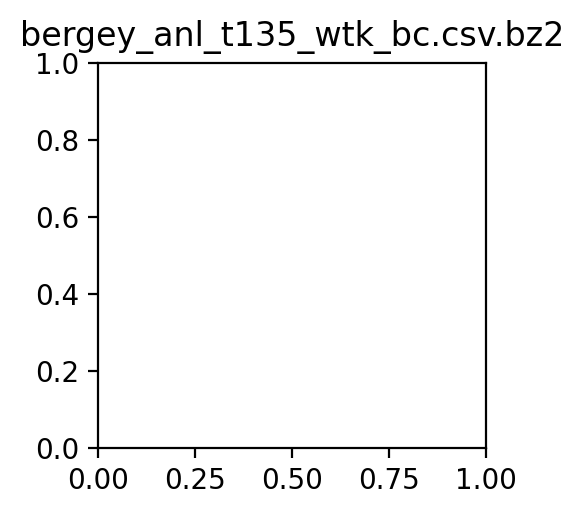

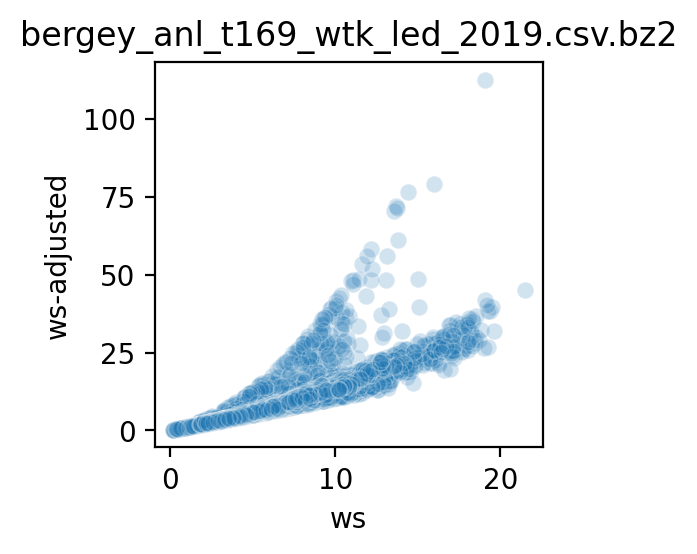

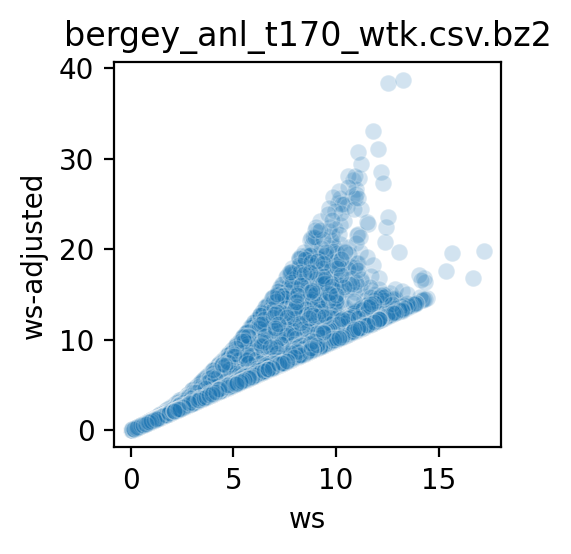

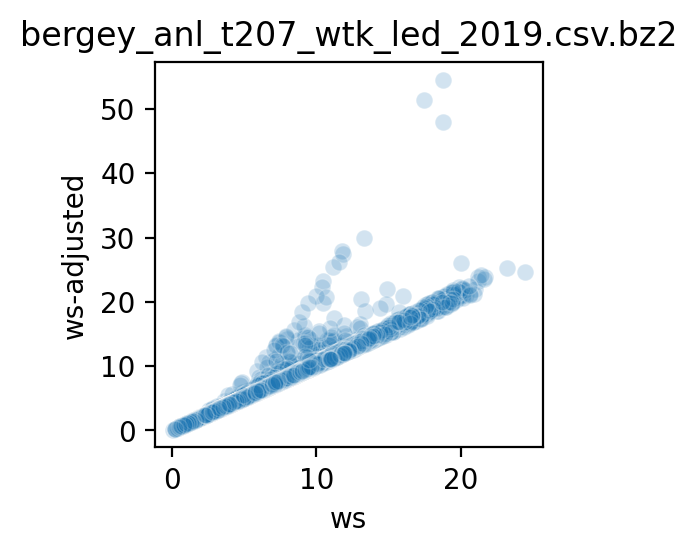

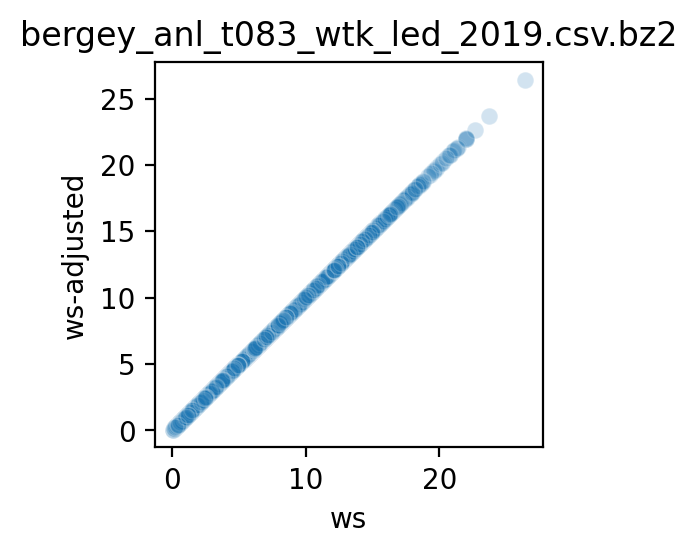

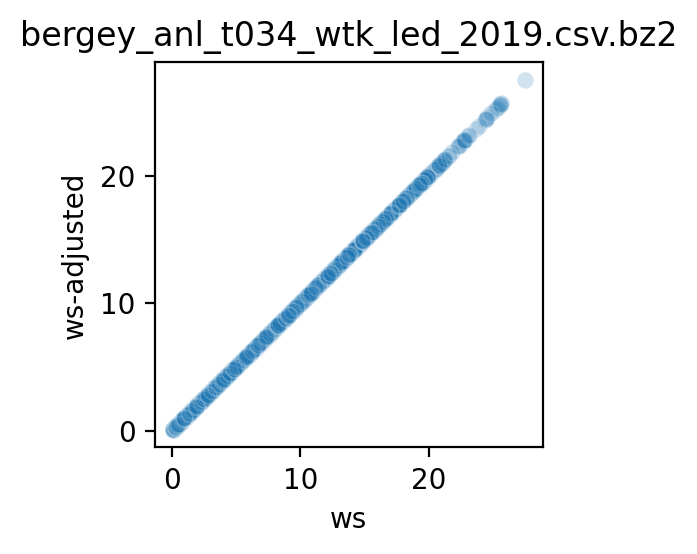

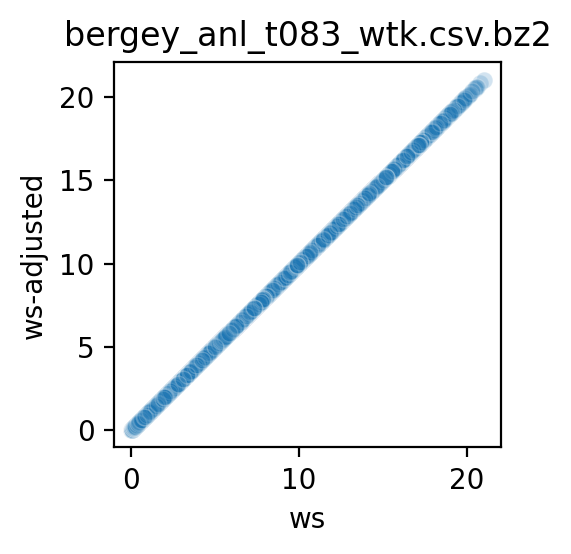

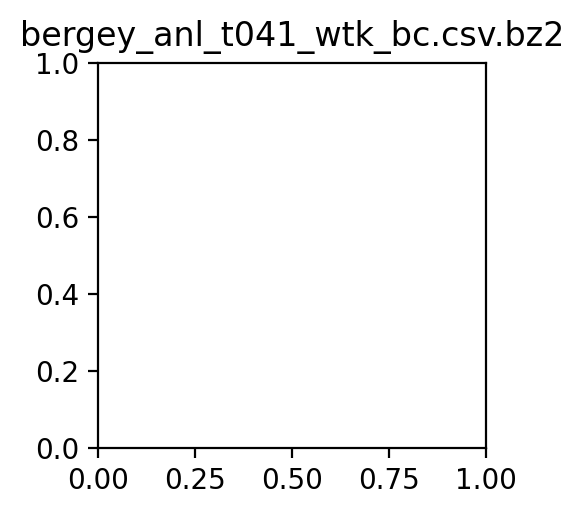

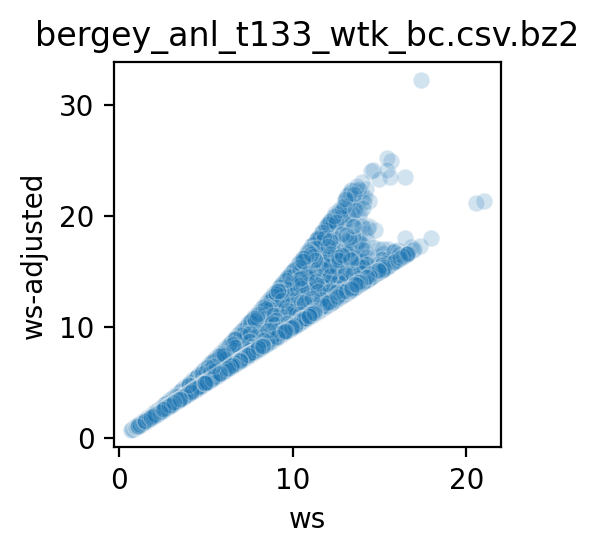

In [12]:
# Quick vis of data in produced files

for f in glob.iglob("%s/*" % dest_dir):
    df = pd.read_csv(f)
    fig = plt.gcf()
    fig.set_size_inches(2.5,2.5)
    sns.scatterplot(x=df["ws"], \
                    y=df["ws-adjusted"], alpha=0.2).set(title=os.path.basename(f));
    plt.show()